# Applying time modulation to materials

In active nanophotonic devices such as electro-optical modulators, materials can be modulated in both space and time. In `Tidy3D`, space-time modulations can be applied to a regular [Medium](../_autosummary/tidy3d.Medium.html), or a dispersive medium such as [Lorentz](../_autosummary/tidy3d.Lorentz.html), or even a spatially varying medium such as [CustomMedium](../_autosummary/tidy3d.CustomMedium.html).

In this tutorial, we illustrate how to define such a modulated material with [ModulationSpec](../_autosummary/tidy3d.ModulationSpec.html) that allows us to apply spatio-temporal modulations to permittivity and electric conductivity. Specifically, we consider transmission spectrum of a harmonically modulated dielectric slab, and show the generation of sidebands in the spectrum.

In [1]:
# standard python imports
import numpy as np
import xarray as xr
import matplotlib.pylab as plt

# tidy3D import
import tidy3d as td
from tidy3d.constants import C_0
from tidy3d import SpatialDataArray
import tidy3d.web as web


First, let us define some basic parameters. A narrow source bandwidth is used so that the sideband is visible.

In [2]:
wvl_um = 1
freq0 = td.C_0 / wvl_um
fwidth = freq0 / 100

run_time = 10 / fwidth

# Thicknesses of slab
t_slab = 1  # um

# space between slabs and sources and PML
spacing = wvl_um

# simulation size
sim_size = Lx, Ly, Lz = (1.0, 1.0, 4 * spacing + t_slab)


## Introduction to space-time modulation

Let's take an electro-optic modulator (**EOM**) as an example where the permittivity is modulated. Similar modulation can be applied to electric conductivity as well, leading to an electro-absorption modulator (**EAM**). Consider that the dielectric function of a passive medium is $\epsilon_s$, once the active modulation is applied, the time-dependent dielectric function in space can be described as the follows,

$$\epsilon(\mathbf{r},t) = \epsilon_s + \delta(\mathbf{r}, t) $$
where the dielectric function is the sum of the passive part $\epsilon_s$ and the modulation function $\delta(\mathbf{r}, t)$. In `Tidy3D`, the modulation function $\delta(\mathbf{r}, t)$ must be separable in space and time, so that it can be written in the following form

$$\delta(\mathbf{r}, t) = \Re \left[\delta_t(t)\delta_r(\mathbf{r})\right]$$

- $\delta_t(t)$ is the time dependence part. In the current `Tidy3D` version, only harmonic time dependence, or continuous waveform is supported. Custom time dependence is expected to be supported in the future. The harmonic time dependence is expressed as,
$$\delta_t(t) = A_t\,\mathrm{exp}(j\phi_t - j2\pi f t)$$
where $A_t$ is modulation amplitude, $\phi_t$ the phase offset, and $f$ the modulation frequency.

- $\delta_r(r)$ describes the spatial dependence, which can be either uniform, or take custom spatial distribution of phase and amplitude,
$$\delta_r(\mathbf{r}) = A_r(\mathbf{r})\, \mathrm{exp}[j\phi_r(\mathbf{r})]$$
where $A_r(\mathbf{r})$ is user-supplied modulation amplitude in space, and $\phi_r(\mathbf{r})$ the user-supplied phase offset in space.

Note that since the modulation function $\delta(\mathbf{r}, t)$ takes the product of the time and space dependencies, the overall modulation amplitude is $A_t\times A_r(\mathbf{r})$, and phase offset $\phi_t + \phi_r(\mathbf{r})$.

## Defining Space-Time Modulated Medium

We start with a passive medium:

In [3]:
permittivity = 2
mat_passive = td.Medium(permittivity=permittivity)


### Time dependence

Let's first define the time dependence part. For continuous wave modulation, it is defined through the class [ContinuousWaveTimeModulation](../_autosummary/tidy3d.ContinuousWaveTimeModulation.html) which takes the field `freq0` for modulation frequency, `amplitude` for modulation amplitude, and `phase` for the phase shift. As a proof of principle, we use a relatively high modulation speed in this tutorial.

In [4]:
modulation_freq = 0.1 * freq0
time_modulation = td.ContinuousWaveTimeModulation(
    freq0=modulation_freq, amplitude=1, phase=0
)


### Space dependence

Next, let's define the space dependence part through [SpaceModulation](../_autosummary/tidy3d.SpaceModulation.html). It takes the fields `amplitude` and `phase`, both can be either a scalar float type, or [SpatialDataAarray](../_autosummary/tidy3d.SpatialDataArray.html). The former indicates that the field is uniform inside the medium, while the latter allows us to provide a custom spatial profile. Let's try the former first, and get to the latter later in the tutorial.

In [5]:
modulation_amplitude = 0.4  # this is a relatively strong modulation to permittivity
space_modulation = td.SpaceModulation(amplitude=modulation_amplitude, phase=0)


### Space-time modulation

Now let's put them together to define [SpaceTimeModulation](../_autosummary/tidy3d.SpaceTimeModulation.html), which is then used to define [ModulationSpec](../_autosummary/tidy3d.ModulationSpec.html) to be supplied to the medium.

In [6]:
modulation = td.SpaceTimeModulation(
    time_modulation=time_modulation, space_modulation=space_modulation
)


Let's modulate only the permittivity. With this space-time modulation profile, the modulation 
amplitude of the relative permittivity is the product of modulation amplitudes in space and time, which is $0.4 \times 1 = 0.4$; and the phase offset is the sum of the phase offsets in space and time, which is $ 0 + 0 = 0$ rad.

In [7]:
modulation_spec = td.ModulationSpec(permittivity=modulation, conductivity=None)
mat_modulated = td.Medium(permittivity=permittivity, modulation_spec=modulation_spec)


To summarize, the medium `mat_modulated` is under continuous wave modulation. The modulation is applied to permittivity uniformly in space. The relative permittivity, which takes the value "2" in its passive form, now varies between "1.6" and "2.4".

## Create and Run Simulation

Let's set up the rest of simulation in computing the transmission spectrum.

First, we define the slab.

In [8]:
unmodulated_slab = td.Structure(
    geometry=td.Box(
        center=(0, 0, 0),
        size=(td.inf, td.inf, t_slab),
    ),
    medium=mat_passive,
)

modulated_slab = unmodulated_slab.updated_copy(medium=mat_modulated)


Next, we define the excitation conditions . We will excite the slab using a normally incident (along z) planewave, polarized along the x direction.

In [9]:
# Here we define the planewave source, placed just in advance (towards negative z) of the slab
source = td.PlaneWave(
    source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
    size=(td.inf, td.inf, 0),
    center=(0, 0, -Lz / 2 + spacing),
    direction="+",
)


Here we define the flux monitor, placed just past (towards positive z) of the slab.

In [10]:
# We are interested in measuring the transmitted flux, so we set it to be an oversized plane.
# The monitor frequencies are set to span several sidebands.
monitor_freqs = np.linspace(
    freq0 - modulation_freq * 3, freq0 + modulation_freq * 3, 500
)
monitor = td.FluxMonitor(
    center=(0, 0, Lz / 2 - spacing),
    size=(td.inf, td.inf, 0),
    freqs=monitor_freqs,
    name="flux",
)


Finally, let's define the simulation object.

**Note** that in Tidy3D, by default the monitor data will be normalized against source spectrum. However, in many time modulation simulations, some of our monitor frequencies are way outside the source bandwidth, where the source spectrum is very close to 0. So it's a bad idea to use it to normalize. To obtain raw transmission data that are not normalized, here we set `normalize_index = None`. For more information about normalization, please refer to [here](https://docs.flexcompute.com/projects/tidy3d/en/latest/faq.html#how-are-results-normalized).

In [11]:
sim_unmodulated = td.Simulation(
    center=(0, 0, 0),
    size=sim_size,
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=20),
    structures=[unmodulated_slab],
    sources=[source],
    monitors=[monitor],
    run_time=run_time,
    boundary_spec=td.BoundarySpec.pml(x=False, y=False, z=True),
    normalize_index=None,
)

sim_modulated = sim_unmodulated.updated_copy(structures=[modulated_slab])


15:34:54 PDT WARNING: monitors[0] contains frequencies outside of the simulation
             frequency range (2.878008e+14, 3.117842e+14)(Hz) as defined by the 
             sources.                                                           

             WARNING: monitors[0] contains frequencies outside of the simulation
             frequency range (2.878008e+14, 3.117842e+14)(Hz) as defined by the 
             sources.                                                           

The warnings are just letting us know that the monitor contains frequencies outside the source bandwidth. This is on purpose. With active modulations, sidebands outside the source bandwidth will be generated. We can ignore them as this is intended.

### Visualize the structure

Let's now plot the structures to confirm that they are defined correctly. In the following figure, we compare the plot of the simulation for a passive slab to that of a modulated slab. As we can see in the plot in the right, the modulated part is marked differently.


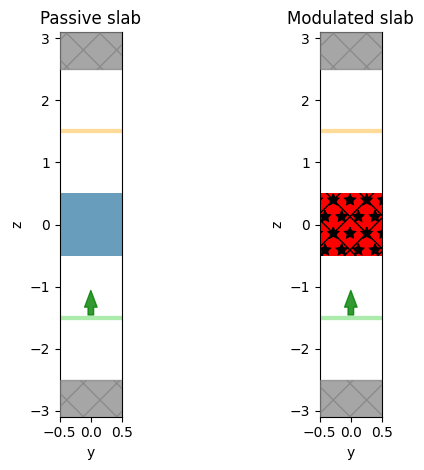

In [12]:
fig, ax = plt.subplots(1, 2, tight_layout=True)
sim_unmodulated.plot(x=0, ax=ax[0])
ax[0].set_title("Passive slab")

sim_modulated.plot(x=0, ax=ax[1])
ax[1].set_title("Modulated slab")
plt.show()


### Run the simulation

In [13]:
sim_data_unmodulated = web.run(sim_unmodulated, task_name="unmodulated", verbose=True)
sim_data_modulated = web.run(sim_modulated, task_name="modulated", verbose=True)


             Created task 'unmodulated' with task_id                            
             'fdve-9aec2409-f357-4f04-bd69-4eed3ff94767v1' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=503939;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9aec2409-f357-4f04-bd69-4eed3ff94767v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=928814;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9aec2409-f357-4f04-bd69-4eed3ff94767v1\taskId]8;;\]8;id=503939;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9aec2409-f357-4f04-bd69-4eed3ff94767v1\=]8;;\]8;id=855657;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9aec2409-f357-4f04-bd69-4eed3ff94767v1\fdve]8;;\]8;id=503939;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9aec2409-f357-4f04-bd69-4eed3ff94767v1\-9aec2409-f35]8;;\
             ]8;id=503939;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9aec2409-f357-4f04-bd69-4eed3ff94767v1\7-4f04-bd69-4eed3ff94767v1']8;;\.

Output()

15:34:56 PDT status = queued

Output()

15:35:05 PDT status = preprocess

15:35:12 PDT Maximum FlexCredit cost: 0.025. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

             running solver

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

15:35:19 PDT early shutoff detected at 16%, exiting.

             status = postprocess

Output()

15:35:23 PDT status = success

             View simulation result at                                          
             ]8;id=127825;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9aec2409-f357-4f04-bd69-4eed3ff94767v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=54272;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9aec2409-f357-4f04-bd69-4eed3ff94767v1\taskId]8;;\]8;id=127825;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9aec2409-f357-4f04-bd69-4eed3ff94767v1\=]8;;\]8;id=760282;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9aec2409-f357-4f04-bd69-4eed3ff94767v1\fdve]8;;\]8;id=127825;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9aec2409-f357-4f04-bd69-4eed3ff94767v1\-9aec2409-f35]8;;\
             ]8;id=127825;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9aec2409-f357-4f04-bd69-4eed3ff94767v1\7-4f04-bd69-4eed3ff94767v1']8;;\.

Output()

15:35:24 PDT loading simulation from simulation_data.hdf5

             WARNING: monitors[0] contains frequencies outside of the simulation
             frequency range (2.878008e+14, 3.117842e+14)(Hz) as defined by the 
             sources.                                                           

             Created task 'modulated' with task_id                              
             'fdve-a0b394b0-5bb4-4314-adbc-007c20c63855v1' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=625663;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a0b394b0-5bb4-4314-adbc-007c20c63855v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=384394;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a0b394b0-5bb4-4314-adbc-007c20c63855v1\taskId]8;;\]8;id=625663;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a0b394b0-5bb4-4314-adbc-007c20c63855v1\=]8;;\]8;id=87714;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a0b394b0-5bb4-4314-adbc-007c20c63855v1\fdve]8;;\]8;id=625663;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a0b394b0-5bb4-4314-adbc-007c20c63855v1\-a0b394b0-5bb]8;;\
             ]8;id=625663;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a0b394b0-5bb4-4314-adbc-007c20c63855v1\4-4314-adbc-007c20c63855v1']8;;\.

Output()

15:35:25 PDT status = queued

Output()

15:35:34 PDT status = preprocess

15:35:40 PDT Maximum FlexCredit cost: 0.025. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

             running solver

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

15:35:48 PDT early shutoff detected at 16%, exiting.

             status = postprocess

Output()

15:35:51 PDT status = success

             View simulation result at                                          
             ]8;id=48449;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a0b394b0-5bb4-4314-adbc-007c20c63855v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=477427;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a0b394b0-5bb4-4314-adbc-007c20c63855v1\taskId]8;;\]8;id=48449;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a0b394b0-5bb4-4314-adbc-007c20c63855v1\=]8;;\]8;id=713954;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a0b394b0-5bb4-4314-adbc-007c20c63855v1\fdve]8;;\]8;id=48449;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a0b394b0-5bb4-4314-adbc-007c20c63855v1\-a0b394b0-5bb]8;;\
             ]8;id=48449;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a0b394b0-5bb4-4314-adbc-007c20c63855v1\4-4314-adbc-007c20c63855v1']8;;\.

Output()

15:35:52 PDT loading simulation from simulation_data.hdf5

             WARNING: monitors[0] contains frequencies outside of the simulation
             frequency range (2.878008e+14, 3.117842e+14)(Hz) as defined by the 
             sources.                                                           

### Postprocess and plot

Since photon number is proportional to the photon energy divided by photon frequency, in the following, we refer to the transmitted flux divided by frequency as photon number.

In [14]:
photon_number_unmodulated = sim_data_unmodulated["flux"].flux / monitor_freqs
photon_number_modulated = sim_data_modulated["flux"].flux / monitor_freqs


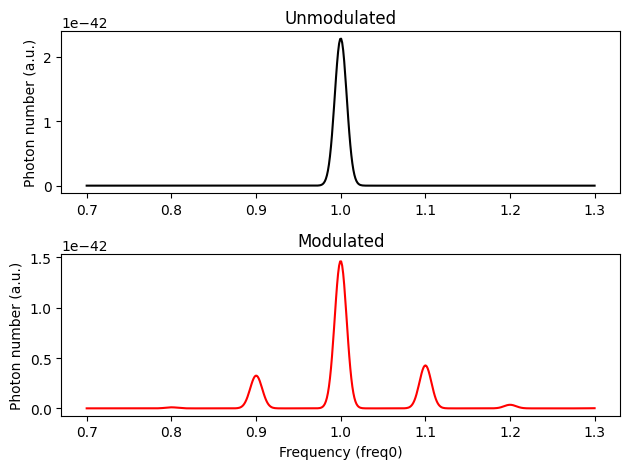

In [15]:
fig, ax = plt.subplots(2, 1, tight_layout=True)
ax[0].plot(monitor_freqs / freq0, photon_number_unmodulated, color="k")
ax[0].set_ylabel("Photon number (a.u.)")
ax[0].set_title("Unmodulated")
ax[1].plot(monitor_freqs / freq0, photon_number_modulated, color="r")
ax[1].set_ylabel("Photon number (a.u.)")
ax[1].set_title("Modulated")
ax[1].set_xlabel("Frequency (freq0)")
plt.show()


The 1st sideband is clearly visible. They are offsetted from the source frequency by the modulation frequency. The 2nd sideband is weak, but still visible.

Next, let's examine if the photon number after the modulation is conserved.

### Photon number conservation

#### Photon number at peak frequencies
Let's compare the photon number at the source frequency in the passive system, to the summed photon number at the source and sideband frequencies in the modulated system. To begin with, let's only count the photon number at peak frequencies.

Since the 2nd sideband is already weak enough, let's ignore photon numbers beyond 2nd sidebands.

In [16]:
# photon number at the peak source frequency in the passive system
photon_number_peak_unmodulated = photon_number_unmodulated.interp(f=freq0)

# photon number at the peak source frequency in the modulated system
photon_number_peak_modulated = photon_number_modulated.interp(f=freq0)

# 1st sideband
photon_number_sideband1 = photon_number_modulated.interp(
    f=freq0 - modulation_freq
) + photon_number_modulated.interp(f=freq0 + modulation_freq)

# 2nd sideband
photon_number_sideband2 = photon_number_modulated.interp(
    f=freq0 - 2 * modulation_freq
) + photon_number_modulated.interp(f=freq0 + 2 * modulation_freq)

# summed photon number in the modulated system
photon_number_sum_modulation = (
    photon_number_peak_modulated + photon_number_sideband1 + photon_number_sideband2
)


In [17]:
photon_number_difference = photon_number_sum_modulation - photon_number_peak_unmodulated
photon_number_rel = float(photon_number_difference / photon_number_peak_unmodulated)
print(
    f"The relative difference of photon number with modulation is {photon_number_rel}"
)


The relative difference of photon number with modulation is -0.008978487924419219


As we can see, the photon number is roughly conserved. Less than $0.9$% photons is missing. The missing photons are attributed to the approximation that we are not counting photons in higher-order sidebands.

#### Photon number integrated over frequencies

The above analysis only counts the photon numbers at peak frequencies, which is valid when the bandwidths of the peaks are identical. Here let's perform a more rigorous analysis by integrating photon number over monitor frequencies to see if the photon number is indeed conserved.

In [18]:
integrated_photon_number_unmodulated = float(photon_number_unmodulated.integrate("f"))
integrated_photon_number_modulated = float(photon_number_modulated.integrate("f"))


In [19]:
photon_number_difference = (
    integrated_photon_number_modulated - integrated_photon_number_unmodulated
)
photon_number_rel = float(
    photon_number_difference / integrated_photon_number_unmodulated
)
print(
    f"The relative difference of photon number with modulation is {photon_number_rel}"
)


The relative difference of photon number with modulation is -0.008746811484164705


The result is the same as counting photon numbers only at peak frequencies.

## More Complicated Modulations

Now just for fun, let's illustrate a more complicated modulation that mimics indirect transitions. On top of a dispersive medium, we apply space-time modulation that is a function of both time and $y$-coordinate:

$$\delta(y, t) = A \cos(-2\pi ft + q y)$$
Where $f$ is the modulation frequency, and $q$ the wavevector.

Below, as an example, we consider the wavevvector $q=\frac{2\pi}{\lambda_0}$, where $\lambda_0$ is the wavelength corresponding to source central frequency. With phase-matching condition, the wavevector along $y$-direction in the 1st sideband will take values $\pm q$. Let's do a quick qualitative analysis of what is expected in the transmission spectrum regarding the 1st sideband:

- The frequency of the lower branch is $f_0 - f$, where $f_0$ is the source central frequency. However, $\frac{c}{2\pi}|q| > (f_0-f)$, so the wave is evanescent and is confined to the slab. The transmission at this frequency is expected to be the same as the unmodulated medium;
- The frequency of the upper branch is $f_0 + f$. Since $\frac{c}{2\pi}|q| < (f_0+f)$, the wave is propagating. It is expected to see up-converted photons in the transmission spectrum.

To summarize, we expect to see only up-conversion in the transmission spectrum. Let's setup the simulation to verify our theory.

In [20]:
# let's consider passive dispersive medium described by Sellmeier model
mat_passive = td.Sellmeier.from_dispersion(
    n=np.sqrt(permittivity), freq=freq0, dn_dwvl=-0.2
)
unmodulated_slab = unmodulated_slab.updated_copy(medium=mat_passive)


Here we consider the same time dependence, but more complicated space dependence as described above.

In [21]:
Nx = 1
Ny = 10
Nz = 11
x = [0]
y = np.linspace(-Ly / 2, Ly / 2, Ny)
z = [0]
coords = dict(x=x, y=y, z=z)
xgrid, ygrid, zgrid = np.meshgrid(x, y, z, indexing="ij")

phase = td.SpatialDataArray(2 * np.pi * ygrid / Ly, coords=coords)

space_modulation = td.SpaceModulation(amplitude=modulation_amplitude, phase=phase)


Finalize the modulated medium setup:

In [22]:
modulation = modulation.updated_copy(space_modulation=space_modulation)
modulation_spec = td.ModulationSpec(permittivity=modulation)
mat_modulated = mat_passive.updated_copy(modulation_spec=modulation_spec)
modulated_slab = modulated_slab.updated_copy(medium=mat_modulated)


### Setup and run simulation

In [23]:
sim_unmodulated = sim_unmodulated.updated_copy(structures=[unmodulated_slab])
sim_modulated = sim_modulated.updated_copy(structures=[modulated_slab])


             WARNING: monitors[0] contains frequencies outside of the simulation
             frequency range (2.878008e+14, 3.117842e+14)(Hz) as defined by the 
             sources.                                                           

             WARNING: monitors[0] contains frequencies outside of the simulation
             frequency range (2.878008e+14, 3.117842e+14)(Hz) as defined by the 
             sources.                                                           

In [24]:
sim_data_unmodulated = web.run(
    sim_unmodulated, task_name="unmodulated_sellmeier", verbose=True
)
sim_data_modulated = web.run(
    sim_modulated, task_name="modulated_sellmeier", verbose=True
)


15:35:53 PDT Created task 'unmodulated_sellmeier' with task_id                  
             'fdve-24b5af63-da83-4464-9c80-1271190025e1v1' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=79961;https://tidy3d.simulation.cloud/workbench?taskId=fdve-24b5af63-da83-4464-9c80-1271190025e1v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=178911;https://tidy3d.simulation.cloud/workbench?taskId=fdve-24b5af63-da83-4464-9c80-1271190025e1v1\taskId]8;;\]8;id=79961;https://tidy3d.simulation.cloud/workbench?taskId=fdve-24b5af63-da83-4464-9c80-1271190025e1v1\=]8;;\]8;id=209127;https://tidy3d.simulation.cloud/workbench?taskId=fdve-24b5af63-da83-4464-9c80-1271190025e1v1\fdve]8;;\]8;id=79961;https://tidy3d.simulation.cloud/workbench?taskId=fdve-24b5af63-da83-4464-9c80-1271190025e1v1\-24b5af63-da8]8;;\
             ]8;id=79961;https://tidy3d.simulation.cloud/workbench?taskId=fdve-24b5af63-da83-4464-9c80-1271190025e1v1\3-4464-9c80-1271190025e1v1']8;;\.

Output()

             status = queued

Output()

15:36:02 PDT status = preprocess

15:36:06 PDT Maximum FlexCredit cost: 0.025. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

             running solver

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

15:36:14 PDT early shutoff detected at 16%, exiting.

             status = postprocess

Output()

15:36:17 PDT status = success

15:36:18 PDT View simulation result at                                          
             ]8;id=476169;https://tidy3d.simulation.cloud/workbench?taskId=fdve-24b5af63-da83-4464-9c80-1271190025e1v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=174910;https://tidy3d.simulation.cloud/workbench?taskId=fdve-24b5af63-da83-4464-9c80-1271190025e1v1\taskId]8;;\]8;id=476169;https://tidy3d.simulation.cloud/workbench?taskId=fdve-24b5af63-da83-4464-9c80-1271190025e1v1\=]8;;\]8;id=484794;https://tidy3d.simulation.cloud/workbench?taskId=fdve-24b5af63-da83-4464-9c80-1271190025e1v1\fdve]8;;\]8;id=476169;https://tidy3d.simulation.cloud/workbench?taskId=fdve-24b5af63-da83-4464-9c80-1271190025e1v1\-24b5af63-da8]8;;\
             ]8;id=476169;https://tidy3d.simulation.cloud/workbench?taskId=fdve-24b5af63-da83-4464-9c80-1271190025e1v1\3-4464-9c80-1271190025e1v1']8;;\.

Output()

             loading simulation from simulation_data.hdf5

             WARNING: monitors[0] contains frequencies outside of the simulation
             frequency range (2.878008e+14, 3.117842e+14)(Hz) as defined by the 
             sources.                                                           

             Created task 'modulated_sellmeier' with task_id                    
             'fdve-82b3a3b4-c3a8-4c39-88e8-92b7dda67fe2v1' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=938244;https://tidy3d.simulation.cloud/workbench?taskId=fdve-82b3a3b4-c3a8-4c39-88e8-92b7dda67fe2v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=162297;https://tidy3d.simulation.cloud/workbench?taskId=fdve-82b3a3b4-c3a8-4c39-88e8-92b7dda67fe2v1\taskId]8;;\]8;id=938244;https://tidy3d.simulation.cloud/workbench?taskId=fdve-82b3a3b4-c3a8-4c39-88e8-92b7dda67fe2v1\=]8;;\]8;id=960938;https://tidy3d.simulation.cloud/workbench?taskId=fdve-82b3a3b4-c3a8-4c39-88e8-92b7dda67fe2v1\fdve]8;;\]8;id=938244;https://tidy3d.simulation.cloud/workbench?taskId=fdve-82b3a3b4-c3a8-4c39-88e8-92b7dda67fe2v1\-82b3a3b4-c3a]8;;\
             ]8;id=938244;https://tidy3d.simulation.cloud/workbench?taskId=fdve-82b3a3b4-c3a8-4c39-88e8-92b7dda67fe2v1\8-4c39-88e8-92b7dda67fe2v1']8;;\.

Output()

15:36:19 PDT status = queued

Output()

15:36:29 PDT status = preprocess

15:36:35 PDT Maximum FlexCredit cost: 0.025. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

             running solver

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

15:36:47 PDT early shutoff detected at 76%, exiting.

             status = postprocess

Output()

15:36:50 PDT status = success

             View simulation result at                                          
             ]8;id=959758;https://tidy3d.simulation.cloud/workbench?taskId=fdve-82b3a3b4-c3a8-4c39-88e8-92b7dda67fe2v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=518564;https://tidy3d.simulation.cloud/workbench?taskId=fdve-82b3a3b4-c3a8-4c39-88e8-92b7dda67fe2v1\taskId]8;;\]8;id=959758;https://tidy3d.simulation.cloud/workbench?taskId=fdve-82b3a3b4-c3a8-4c39-88e8-92b7dda67fe2v1\=]8;;\]8;id=619446;https://tidy3d.simulation.cloud/workbench?taskId=fdve-82b3a3b4-c3a8-4c39-88e8-92b7dda67fe2v1\fdve]8;;\]8;id=959758;https://tidy3d.simulation.cloud/workbench?taskId=fdve-82b3a3b4-c3a8-4c39-88e8-92b7dda67fe2v1\-82b3a3b4-c3a]8;;\
             ]8;id=959758;https://tidy3d.simulation.cloud/workbench?taskId=fdve-82b3a3b4-c3a8-4c39-88e8-92b7dda67fe2v1\8-4c39-88e8-92b7dda67fe2v1']8;;\.

Output()

15:36:51 PDT loading simulation from simulation_data.hdf5

             WARNING: monitors[0] contains frequencies outside of the simulation
             frequency range (2.878008e+14, 3.117842e+14)(Hz) as defined by the 
             sources.                                                           

### Postprocess and plot
Let's perform the same visualization of the results.

In [25]:
photon_number_unmodulated = sim_data_unmodulated["flux"].flux / monitor_freqs
photon_number_modulated = sim_data_modulated["flux"].flux / monitor_freqs


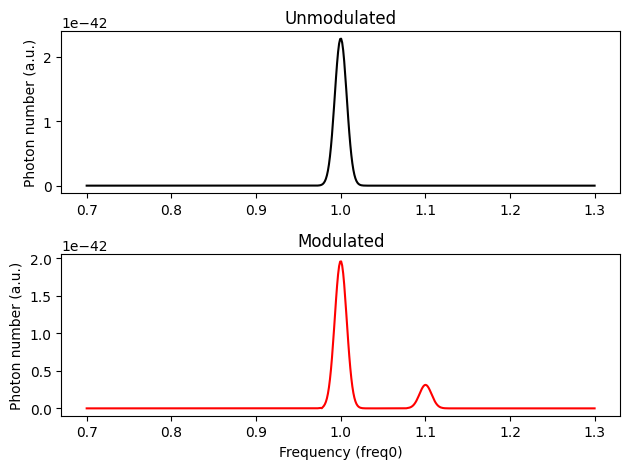

In [26]:
fig, ax = plt.subplots(2, 1, tight_layout=True)
ax[0].plot(monitor_freqs / freq0, photon_number_unmodulated, color="k")
ax[0].set_ylabel("Photon number (a.u.)")
ax[0].set_title("Unmodulated")
ax[1].plot(monitor_freqs / freq0, photon_number_modulated, color="r")
ax[1].set_ylabel("Photon number (a.u.)")
ax[1].set_title("Modulated")
ax[1].set_xlabel("Frequency (freq0)")
plt.show()


Indeed, we only see up-conversion in the 1st sideband.

## Notes:
- When subpixel averaging is on, it will be applied to the passive part of the medium, but not to the active modulation part.
- In dispersive medium, modulation can be applied to relative permittivity at infinite frequency `eps_inf` and `conductivity`. Modulation to other fields such as dispersive coefficients is expected in the future.
- When modulation is applied to relative permittivity at infinite frequency, `eps_inf` must be positive at any time. The time step will be adjusted accordingly to the minimum value of `eps_inf`to meet CFL condition; Similarly, when modulation is applied to conductivity, the conductivity must be non-negative at any time, unless `allow_gain` is set to be `True`.